# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
import numpy as np
import pandas as pd
import math

import seaborn as sns

from scipy.spatial import distance

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors as nbr
import sklearn.preprocessing

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

from IPython.display import display

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
try:
    df = pd.read_csv('insurance_us.csv')
except:
    df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

gender   age   income  family_members  insurance_benefits
2735       1  22.0  41300.0               1                   0
3231       0  35.0  22700.0               2                   0
3384       0  18.0  46200.0               1                   0
3171       0  31.0  34300.0               2                   0
4132       1  33.0  29300.0               0                   0
2955       1  32.0  21600.0               0                   0
2241       0  36.0  22800.0               2                   0
3695       1  40.0  39700.0               3                   0
4131       0  33.0  36700.0               0                   0
4236       0  20.0  43000.0               1                   0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
gender                5000 non-null int64
age                   5000 non-null float64
income                5000 non-null float64
family_members        5000 non-null int64
insurance_benefits    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# we may want to fix the age type (from float to int) though this is not critical
df.gender = pd.to_numeric(df.gender, downcast='integer')
df.age = pd.to_numeric(df.age, downcast='integer')
df.income = pd.to_numeric(df.income, downcast='float')
df.family_members = pd.to_numeric(df.family_members, downcast='integer')
df.insurance_benefits = pd.to_numeric(df.insurance_benefits, downcast='integer')

Now let's check to see that the conversion was successful

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
gender                5000 non-null int8
age                   5000 non-null int8
income                5000 non-null float32
family_members        5000 non-null int8
insurance_benefits    5000 non-null int8
dtypes: float32(1), int8(4)
memory usage: 39.2 KB


now let's have a look at the data's descriptive statistics. Does everything look okay?

In [10]:
df.describe()

gender          age        income  family_members  \
count  5000.000000  5000.000000   5000.000000     5000.000000   
mean      0.499000    30.952800  39916.359375        1.194200   
std       0.500049     8.440807   9900.083984        1.091387   
min       0.000000    18.000000   5300.000000        0.000000   
25%       0.000000    24.000000  33300.000000        0.000000   
50%       0.000000    30.000000  40200.000000        1.000000   
75%       1.000000    37.000000  46600.000000        2.000000   
max       1.000000    65.000000  79000.000000        6.000000   

       insurance_benefits  
count         5000.000000  
mean             0.148000  
std              0.463183  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              0.000000  
max              5.000000

The gender seems to be nearly an even split, which is likely a sampling choice. We have a range of 18 to 65 years old and a seemingly well represented group from the income. The number of family members seems to be more representative of individuals on plans without family members, but groups of up to 6 are still in the sample. The number of insurance benefits are skewed, where a majority of samples are zero, but up to 5 are observed.

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

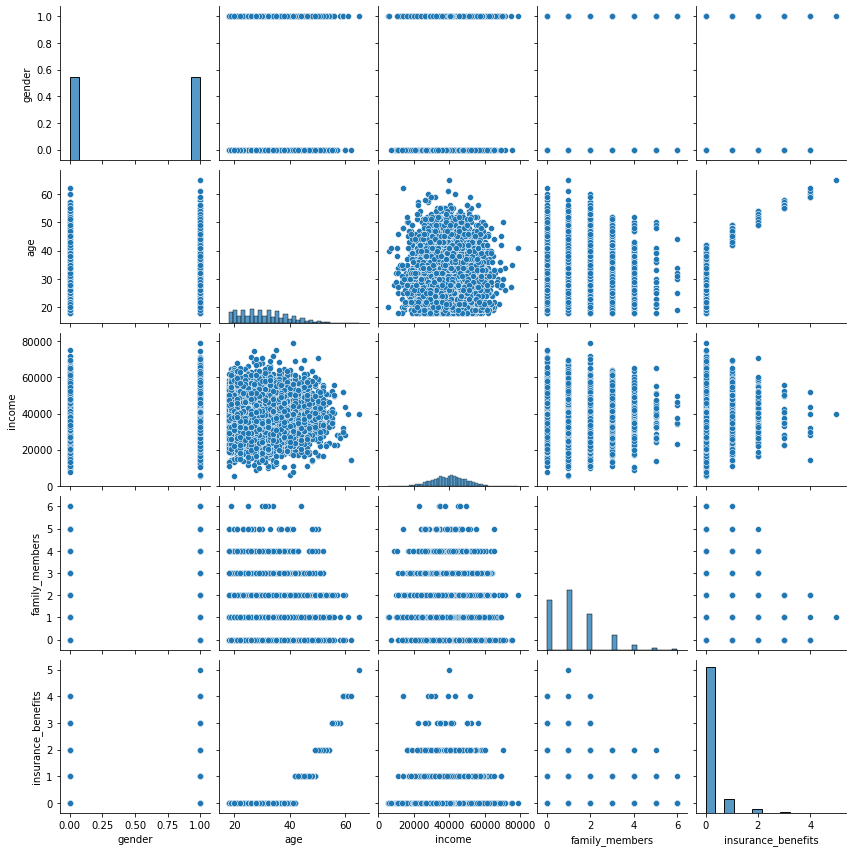

In [11]:
g = sns.pairplot(df)
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [12]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [13]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = nbr.NearestNeighbors(n_neighbors=k, metric=metric).fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [14]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [15]:
df_scaled.sample(5)

gender       age    income  family_members  insurance_benefits
2970     1.0  0.492308  0.216456        0.500000                   0
2325     0.0  0.661538  0.326582        0.000000                   1
2155     1.0  0.861538  0.511392        0.000000                   3
2068     0.0  0.584615  0.559494        0.500000                   0
3292     0.0  0.569231  0.546835        0.333333                   0

Now, let's get similar records for a given one for every combination

In [16]:
get_knn(df, 2000, 10, 'euclidean')

gender  age   income  family_members  insurance_benefits  distance
2000       0   34  29000.0               2                   0  0.000000
1275       1   34  29000.0               1                   0  1.414214
4385       1   36  29000.0               2                   0  2.236068
310        0   36  29000.0               0                   0  2.828427
1837       1   31  29000.0               2                   0  3.162278
273        1   39  29000.0               3                   0  5.196152
4638       1   28  29000.0               1                   0  6.164414
4637       0   41  29000.0               2                   0  7.000000
1544       0   25  29000.0               1                   0  9.055385
4461       1   43  29000.0               1                   1  9.110434

In [17]:
get_knn(df_scaled, 2000, 10, 'euclidean')

gender       age    income  family_members  insurance_benefits  distance
2000     0.0  0.523077  0.367089        0.333333                   0  0.000000
3936     0.0  0.538462  0.370886        0.333333                   0  0.015846
4780     0.0  0.507692  0.360759        0.333333                   0  0.016636
3608     0.0  0.538462  0.374684        0.333333                   0  0.017157
2931     0.0  0.523077  0.348101        0.333333                   0  0.018987
175      0.0  0.507692  0.387342        0.333333                   0  0.025434
4783     0.0  0.523077  0.393671        0.333333                   0  0.026582
3921     0.0  0.507692  0.340506        0.333333                   0  0.030713
3333     0.0  0.553846  0.375949        0.333333                   0  0.032020
2519     0.0  0.553846  0.375949        0.333333                   0  0.032020

In [18]:
get_knn(df, 2000, 10, 'manhattan')

gender  age   income  family_members  insurance_benefits  distance
2000       0   34  29000.0               2                   0       0.0
1275       1   34  29000.0               1                   0       2.0
4385       1   36  29000.0               2                   0       3.0
310        0   36  29000.0               0                   0       4.0
1837       1   31  29000.0               2                   0       4.0
4637       0   41  29000.0               2                   0       7.0
273        1   39  29000.0               3                   0       7.0
4638       1   28  29000.0               1                   0       8.0
1544       0   25  29000.0               1                   0      10.0
4441       0   24  29000.0               1                   0      11.0

In [19]:
get_knn(df_scaled, 2000, 10, 'manhattan')

gender       age    income  family_members  insurance_benefits  distance
2000     0.0  0.523077  0.367089        0.333333                   0  0.000000
2931     0.0  0.523077  0.348101        0.333333                   0  0.018987
3936     0.0  0.538462  0.370886        0.333333                   0  0.019182
4780     0.0  0.507692  0.360759        0.333333                   0  0.021714
3608     0.0  0.538462  0.374684        0.333333                   0  0.022980
4783     0.0  0.523077  0.393671        0.333333                   0  0.026582
175      0.0  0.507692  0.387342        0.333333                   0  0.035638
3333     0.0  0.553846  0.375949        0.333333                   0  0.039630
2519     0.0  0.553846  0.375949        0.333333                   0  0.039630
1894     0.0  0.553846  0.358228        0.333333                   0  0.039630

Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Depending on the units, the scaling can significantly affect the kNN algorithm. In a typical coordinate system, the kNN algorithm sees the distance between one customer's gender to another a maximum distance of 1. This means that changing gender has the nearly the same impact as someone who has, for example, a salary of 29000 and another person making 29001.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

The results are very similar between the euclidean and manhattan distance metrics. In the 10 returned samples, they share nearly identical results, but sometimes the order is a bit different. This makes sense, as one is the square root of the sums of the squares of the distances, and the other is just the sums of the distances. With only 4 features, the distance metric does not change much. But with many more features, this may not be the case.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [20]:
# calculate the target

df['insurance_benefits_received'] = df['insurance_benefits'].where(df['insurance_benefits'] < 1, 1)

In [21]:
# check for the class imbalance with value_counts()

df['insurance_benefits_received'].value_counts()

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

In [22]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    print('Confusion Matrix')
    print(cm)

In [23]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [24]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, 5000)
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[4436    0]
 [ 564    0]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[3957  479]
 [ 497   67]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[2280 2156]
 [ 265  299]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[   0 4436]
 [   0  564]]



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


The best F1 we could get with a dummy model is .20. Let's see what a kNN Model can do for us.

In [25]:
def run_knn(features_train, target_train, features_test, target_test, k, metric):
    features_train = features_train.reset_index(drop=True)
    target_train = target_train.reset_index(drop=True)
    features_test = features_test.reset_index(drop=True)
    target_test = target_test.reset_index(drop=True)
    
    """
    Prints the f1 score and confusion matrix for the KNN Classifier

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    
    neigh = KNeighborsClassifier(n_neighbors=k, metric=metric)
    neigh.fit(features_train, target_train)
    preds = neigh.predict(features_test)        
    print('k:', k)
    print(eval_classifier(target_test, preds))

In [26]:
features = df[feature_names]
target = df['insurance_benefits_received']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [27]:
for k in range(1,11):
    run_knn(X_train, y_train, X_test, y_test, k, 'euclidean')

k: 1
F1: 0.65
Confusion Matrix
[[1312   27]
 [  70   91]]
None
k: 2
F1: 0.38
Confusion Matrix
[[1336    3]
 [ 123   38]]
None
k: 3
F1: 0.39
Confusion Matrix
[[1325   14]
 [ 119   42]]
None
k: 4
F1: 0.16
Confusion Matrix
[[1334    5]
 [ 147   14]]
None
k: 5
F1: 0.17
Confusion Matrix
[[1325   14]
 [ 145   16]]
None
k: 6
F1: 0.09
Confusion Matrix
[[1338    1]
 [ 153    8]]
None
k: 7
F1: 0.12
Confusion Matrix
[[1337    2]
 [ 151   10]]
None
k: 8
F1: 0.02
Confusion Matrix
[[1339    0]
 [ 159    2]]
None
k: 9
F1: 0.04
Confusion Matrix
[[1339    0]
 [ 158    3]]
None
k: 10
F1: 0.04
Confusion Matrix
[[1339    0]
 [ 158    3]]
None


In [28]:
features = df_scaled[feature_names]
target = df['insurance_benefits_received']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [29]:
for k in range(1,11):
    run_knn(X_train, y_train, X_test, y_test, k, 'euclidean')

k: 1
F1: 0.93
Confusion Matrix
[[1332    7]
 [  14  147]]
None
k: 2
F1: 0.92
Confusion Matrix
[[1336    3]
 [  22  139]]
None
k: 3
F1: 0.94
Confusion Matrix
[[1334    5]
 [  14  147]]
None
k: 4
F1: 0.91
Confusion Matrix
[[1337    2]
 [  24  137]]
None
k: 5
F1: 0.94
Confusion Matrix
[[1334    5]
 [  15  146]]
None
k: 6
F1: 0.91
Confusion Matrix
[[1337    2]
 [  26  135]]
None
k: 7
F1: 0.93
Confusion Matrix
[[1335    4]
 [  18  143]]
None
k: 8
F1: 0.91
Confusion Matrix
[[1338    1]
 [  25  136]]
None
k: 9
F1: 0.93
Confusion Matrix
[[1337    2]
 [  19  142]]
None
k: 10
F1: 0.91
Confusion Matrix
[[1338    1]
 [  25  136]]
None


Both the scaled and not scaled data produced a better f1 score with the kNN model than the dummy model. However, the scaled data performed exceptionally well, getting f1 scores of 0.94 while the unscaled data got a score of 0.65.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated target (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [30]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = ((np.linalg.inv(X2.T @ X2)) @ (X2.T)) @ y

    def predict(self, X):
        
        # adding the unities
        X2 = X @ (self.weights[1:])
        y_pred = X2 + self.weights[0]
        
        return y_pred

In [31]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [32]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [33]:
X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.94353898  2.32372055  0.01642727 -0.02059874 -0.07014128]
RMSE: 0.34
R2: 0.66


As for the Linear Regression, we can see that differences between scaling the data are not found. This is likely because the weights are not uniformly decided, such as the units of measure in a kNN Classification.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the invertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Mupliplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [34]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [35]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [36]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [37]:
print(np.linalg.inv(P))

[[ 0.41467992 -1.43783972  0.62798546  1.14001268]
 [-1.06101789  0.44219337  0.1329549   1.18425933]
 [ 1.42362442  1.60461607 -2.0553823  -1.53699695]
 [-0.11128575 -0.65813802  1.74995517 -0.11816316]]


Can you guess the customers' ages or income after the transformation?

In [38]:
X_p = X.dot(P)
print(X_p[:,1]/X[:,1])

[545.86352869 373.05145717 327.11716359 ... 764.46206325 670.54504655
 654.08029087]


Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [39]:
X_pp = X_p.dot(np.linalg.inv(P))

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [40]:
print(X)
print(X_p)
print(X_pp)

[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]
[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]
[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [ 1.67952800e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-6.23021448e-13  2.90000000e+01  2.10000000e+04 -2.03032656e-13]
 ...
 [ 1.57996161e-12  2.00000000e+01  3.39000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.20000000e+01  3.27000000e+04  3.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  4

You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

There are some slight deviations in some of the numbers, but we see those are on the order of 10^(-12). There would be some errors caused by math with finite storage. Rounding occurs, and some precision is lost.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

The replationship between an original matrix and its obfuscated matrix, the only difference is with the inverse of the obfuscating matrix, $P$. Because the obfuscating is done across all data observations, the effect is the same between them and the linear regression has the same RMSE between the two matrices.

**Analytical proof**

$$
w_p = [(X^TP^T)XP]^{-1}(X^TP^T)y
$$

$$
w_p = [(XP)^{-1}(XP)^{-T}](X^TP^T)y
$$

$$
w_p = (XP)^{-1}[(XP)(XP)^{-1}]^Ty
$$

$$
w_p = (XP)^{-1}[I]^Ty
$$

$$
w_p = (XP)^{-1}y
$$

$$
w_p = P^{-1}X^{-1}y
$$

$$
w_p = P^{-1}X^{-1}X^{-T}X^Ty
$$

$$
w_p = P^{-1}(X^{T}X)^{-1}X^Ty
$$

$$
w_p = P^{-1}w
$$

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- Use $XP$ as the new feature matrix

In [41]:
rng = np.random.default_rng(seed=123)
P = rng.random(size=(X.shape[1], X.shape[1]))
P_inv = np.linalg.inv(P)
P_inv

array([[ 2.19450806, -0.03188876,  0.05217293, -0.64857954],
       [-2.32630105, -0.66611646,  1.8073291 ,  0.27050733],
       [ 3.47767967,  2.46318223, -2.15521329, -1.2612122 ],
       [-6.1753682 , -2.63150913,  1.85521818,  3.82879052]])

In [42]:
X_p = X.dot(P)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()
lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

RMSE: 0.34
R2: 0.66


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_p, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()
lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

RMSE: 0.34
R2: 0.66


We see that there are no differences in the RMSE and the R2 values, so data obfuscation does not affect these in the model fitting and testing process.

# Conclusions

In this project, we were given a dataset of insurance customers, some of their representative data, and the number of claimed benefits, which was our target during modeling. The data was clean, and we only had to optimize the storage sizes. Looking at the data preliminarily, we saw a well represented sample of genders, ages, salaries, and family members. 

We then used a kNN Algorithm to confirm that our dataset was only affected a minor amount if we used euclidean or manhattan distances to find the nearest neighbors. However, scaling the data added weight to the features, so that a male customer and a female customer were not compared as if it was a customer than made a miniscule amount more in annual salary. Therefore, scaling was imperative to a kNN Classifying model's success.

We then created a dummy model, and used a 70/30 train and test split to verify if the classifier could reasonably predict if a customer received any insurance benefits in the last five years. The Classifier was reaching f1 scores of about 94%--well above the 20% f1 score of the dummy model. This also beat out a 65% score from an unscaled dataset, further proving that scaling is necessary. We could confirm that the kNN was successful. 

We then created our own Linear Regression model. The model used linear algebra to create weights of each feature that we could then apply to a predict the same outcome as the kNN Classifier, similar to what is available in the sklearn library. With our Linear Regression model, we wanted to see how scaling would affect this model type's outcome. Because the model creates it's own weights, unlike the kNN Classifier, scaling the data did not affect the results. The RMSE and R$^2$ values were the same, regardless of the input. 

Lastly, we explored Data Obfuscation with a random, invertible matrix, $P$. We saw and proved that the data was incomprehensible and secured the privacy of the information, but then multiplying it by the inverse of $P$ returned the data to its original form. Using the Linear Regression model, we found that the results were unaffected by obfuscation. The weights are different, but the error in prediction was the same, as the weights were only scaled by the matrix $P^{-1}$.